# Strømforbruk i Norge

- Kilde: https://www.ssb.no/statbank/table/08307/
- Enhet: GWh / GVAh

In [24]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
import statsmodels.api as sm
from datetime import timedelta, datetime

In [16]:
df = pd.read_csv("elektrisitet-forbruk.csv", delimiter=";", encoding="latin1")
df["år"] = pd.to_datetime(df["år"], format="%Y")

In [49]:
def index_to_datetime(index):
    year = int(df["år"].iat[0].year + index)
    days_in_year = (datetime(year + 1, 1, 1) - datetime(year, 1, 1)).days  # Handle leap years
    return datetime(year, 1, 1)  + timedelta(days=(index % 1) * days_in_year)

In [17]:
df

,år,Bruttoforbruk,Nettoforbruk
0,1950-01-01,16924,14749
1,1955-01-01,22600,19715
2,1960-01-01,31253,27509
3,1961-01-01,33503,29989
4,1962-01-01,37453,33789
...,...,...,...
61,2019-01-01,134926,126051
62,2020-01-01,133725,126422
63,2021-01-01,139529,131931
64,2022-01-01,133420,125154


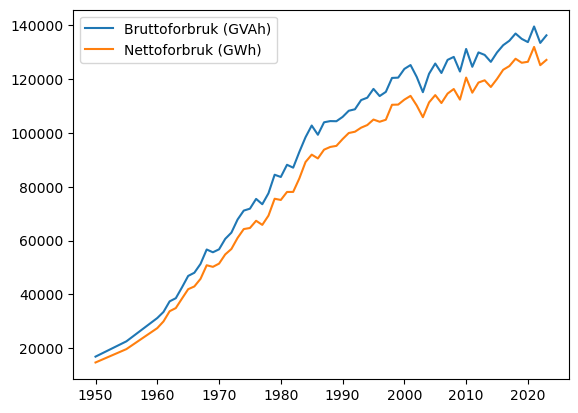

In [23]:
plt.plot(df["år"], df["Bruttoforbruk"], label="Bruttoforbruk (GVAh)")
plt.plot(df["år"], df["Nettoforbruk"], label="Nettoforbruk (GWh)")
plt.legend()

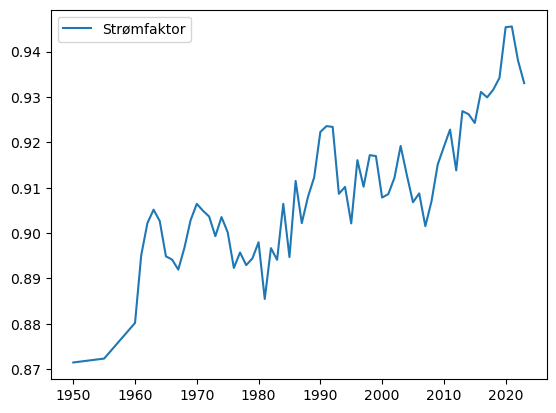

In [354]:
pf = df["Nettoforbruk"] / df["Bruttoforbruk"]
plt.plot(df["år"], pf, label="Strømfaktor")
plt.legend()

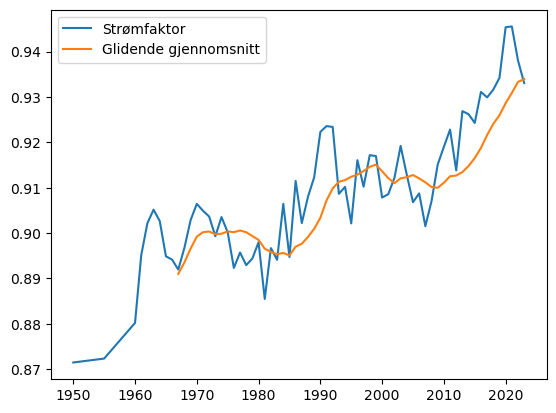

In [68]:
pf_smoothed = pf.rolling(window=10).mean()

plt.plot(df["år"], pf, label="Strømfaktor")
plt.plot(df["år"], pf_smoothed, label="Glidende gjennomsnitt")

plt.legend()

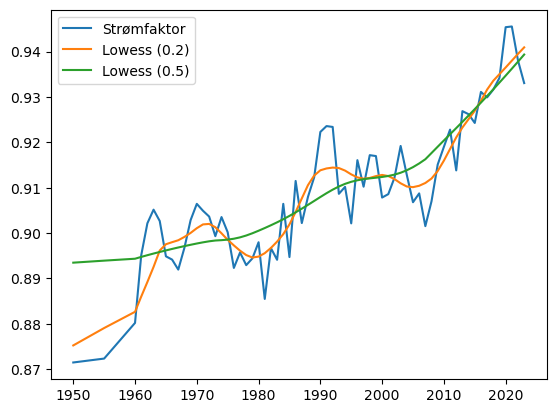

In [67]:
pf_lowess1 = sm.nonparametric.lowess(pf, df.index, frac=0.2, return_sorted=False)
pf_lowess2 = sm.nonparametric.lowess(pf, df.index, frac=0.5, return_sorted=False)

plt.plot(df["år"], pf, label="Strømfaktor")
plt.plot(df["år"], pf_lowess1, label="Lowess (0.2)")
plt.plot(df["år"], pf_lowess2, label="Lowess (0.5)")

plt.legend()

## Regresjonsanalyse

Data ser ut til å øke eksponentielt eller lineære, *men*  vet at strømfaktoren alltid er $\leq 1$. Derfor vil det ikke være passende å bruke lineær eller eksponentiell vekst, så jeg bruker logistisk vekst med en asymptote $y = 1$.

In [287]:
def model_exp(t, a, b):
    return a * b ** t

def model_linear(t, a, b):
    return a + b * t

def model_polynomial(t, a, b, c):
    return a * t ** 2 + b * t + c

In [364]:
coeffs_exp, _ = curve_fit(model_exp, df.index, pf)
coeffs_linear, _ = curve_fit(model_linear, df.index, pf)
coeffs_polynomial, _ = curve_fit(model_linear, df.index, pf)

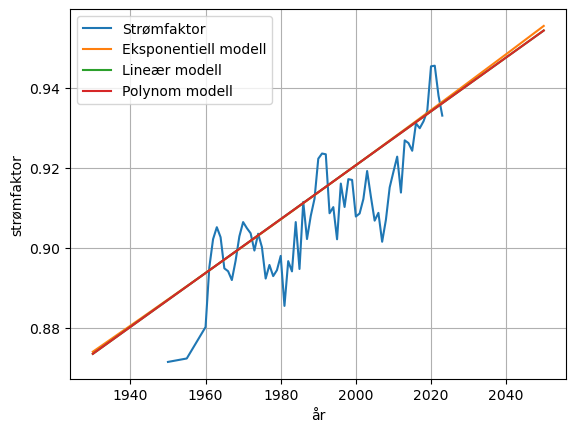

In [363]:
xs_model = np.linspace(-20, 100, 1000)
ys_model1 = model_exp(xs_model, *coeffs_exp)
ys_model2 = model_linear(xs_model, *coeffs_linear)
ys_model3 = model_linear(xs_model, *coeffs_polynomial)
xs_model = [index_to_datetime(x) for x in xs_model]

plt.plot(df["år"], pf, label="Strømfaktor")
plt.plot(xs_model, ys_model1, label="Eksponentiell modell")
plt.plot(xs_model, ys_model2, label="Lineær modell")
plt.plot(xs_model, ys_model3, label="Polynom modell")

plt.xlabel("år")
plt.ylabel("strømfaktor")

plt.legend()
plt.grid()

In [346]:
def model_logistic(t, a, b, C):
    return C / (1 + a * np.exp(-b * t))

def _model_logistic(C, a1, a2):
    # Logistic model with fixed asymptotes and C
    return lambda t, a, b: a1 + (a2 - a1) * (C / (1 + a * np.exp(-b * t)))

model_logistic1 = _model_logistic(1, 0.88, 1)
model_logistic2 = _model_logistic(1, 0.85, 0.95)

In [347]:
a = (1 / pf.iat[0]) - 1
b = 0.05
coeffs_logistic1, _ = curve_fit(model_logistic1, df.index, pf, p0=[a, b], bounds=([0, 0], [100, 10]))
coeffs_logistic2, _ = curve_fit(model_logistic2, df.index, pf, p0=[a, b], bounds=([0, 0], [100, 10]))

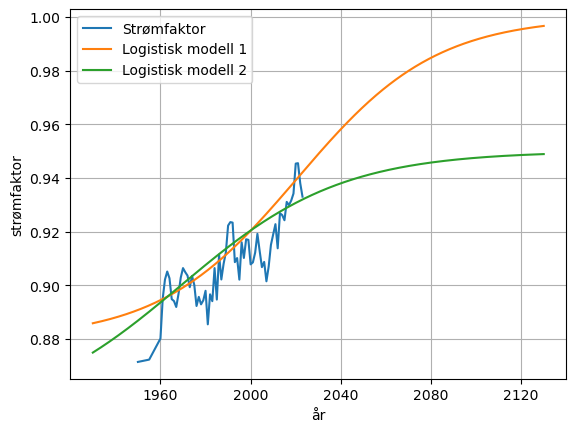

In [365]:
xs_model = np.linspace(-20, 180, 1000)
ys_model1 = model_logistic1(xs_model, *coeffs_logistic1)
ys_model2 = model_logistic2(xs_model, *coeffs_logistic2)
xs_model = [index_to_datetime(x) for x in xs_model]

plt.plot(df["år"], pf, label="Strømfaktor")
# Manuelt tilpassede logistiske modeller
plt.plot(xs_model, ys_model1, label="Logistisk modell 1")
plt.plot(xs_model, ys_model2, label="Logistisk modell 2")

plt.xlabel("år")
plt.ylabel("strømfaktor")

plt.legend()
plt.grid()